# CIFAR-10 이미지 생성하기

## - 목차
1. 데이터셋 구성
2. 생성자 모델 구현
3. 판별자 모델 구현
4. 손실함수와 최적화 함수 구현
5. 훈련과정 상세 기능 구현
6. 학습 과정 진행
7. (optional) GAN 훈련 과정 개선   

- 프로젝트 정리

## 1. 데이터셋 구성

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt


cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [2]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


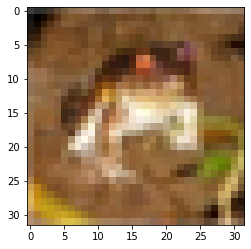

In [3]:
plt.imshow(train_x[0])
plt.show()

In [4]:
#이미지를 [-1, 1]로 정규화.
#중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줌.

train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x[0].dtype

dtype('float64')

In [6]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


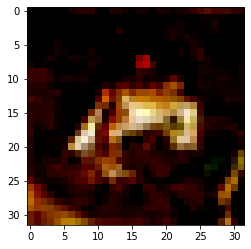

In [7]:
#로드 한 이미지 시각화 통해 확인
plt.imshow(train_x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

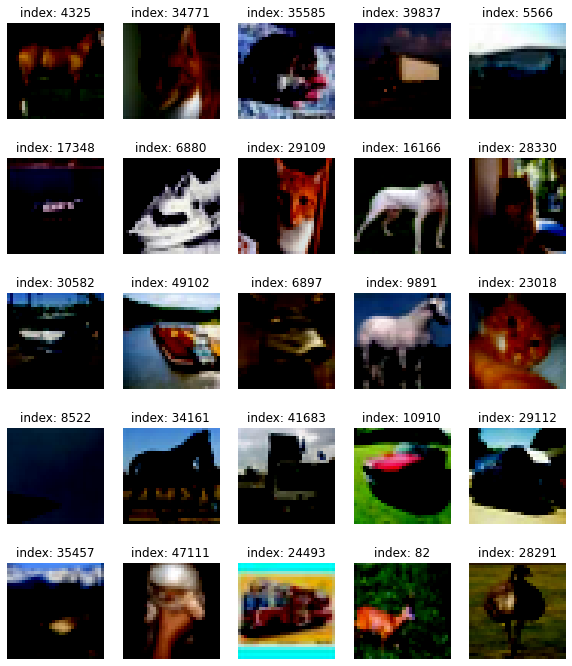

In [8]:
#랜덤으로 정규화 한 이미지 추출

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- plt.imshow는 0 ~ 1 또는 0 ~ 255 사이의 정수형만 표현을 할 수 있음.   
- 때문에 -1 ~ 1 사이로 정규화 시킨 이미지는 오류 메세지를 띄우며 자동으로 0 ~ 1 사이의 값으로 리스케일 되어 출력됨.    
- 뒤에 샘플 이미지를 생성할 때는 역 정규화를 시켜 0 ~ 255 사이의 정수형 값으로 바꿔주어야 함.   

In [9]:
#미니배치 데이터셋 구성
BUFFER_SIZE = 5000   #BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정.
BATCH_SIZE = 256   #BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

- 데이터가 잘 섞이게 하기 위해 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋음. 때문에 50000으로 설정함.

## 2. 생성자 모델 구현

In [10]:
#생성자 구현
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- Conv2DTranspose : 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층.
- 위 모델은 세 번의 Conv2DTranspose 층을 이용해 이미지를 키워나감.
- 최종사이즈가 준비한 데이터셋과 형상이 동일한지(32,32,3) 확인해야 함.
- BatchNormalization : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜 줌.
- 중간층들의 활성화 함수는 모두 LeakyReLU를 사용.
- 마지막 층에는 활성화 함수로 tanh를 사용 : -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

In [11]:
#생성모델
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

In [12]:
#shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성 해 결과물 도출.
#우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만듦.
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)   #훈련 중이 아니니 training=False로 설정.
generated_image.shape

TensorShape([1, 32, 32, 3])

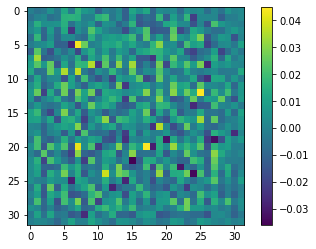

In [14]:
#matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정.
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

- 아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성.

## 3. 판별자 모델 구현

In [15]:
#판별자 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

- 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 핌.
- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력.

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)             

In [17]:
#위에서 생성했던 가짜 이미지를 판별자에 입력시켜 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00196841]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력이 되며 이 값 또한 아직은 아무런 의미가 없는 값일 것.

## 4. 손실함수와 최적화 함수 구현

### 4.1 손실함수

In [18]:
#loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용.
- 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰임.
- 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것.

In [19]:
#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- fake_output가 1에 가까워지기를 바라므로 tf.ones_like와의 교차 엔트로피 값을 계산하면 됨.
- ross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [20]:
#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산함.
- 최종 discriminator_loss 값은 이 둘을 더한 값.

In [21]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 4.2 최적화 함수

In [22]:
#생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 함.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)
seed

(16, 100)


<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.646415  ,  1.3314238 ,  0.26956975, ...,  0.25441903,
         0.6351012 , -0.7886654 ],
       [-0.98041505, -1.0114683 ,  0.5603032 , ...,  1.1821585 ,
        -0.7003201 ,  0.866769  ],
       [-0.5189919 ,  1.7264836 , -1.4552683 , ...,  0.18727504,
         0.4348504 , -0.37421927],
       ...,
       [ 0.6190416 ,  1.1641287 ,  1.0133678 , ..., -0.13081744,
         1.623326  ,  0.42010552],
       [-1.7478148 , -0.25809604,  1.6029156 , ...,  0.77204776,
         0.02073246,  0.4461758 ],
       [ 0.45799124, -1.5957894 , -0.7668239 , ...,  0.08288567,
         0.45406193,  1.8169079 ]], dtype=float32)>

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인.
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어둠

## 5. 훈련 과정 상세 기능 구현
- 하나의 미니배치 당 진행할 train_step 함수를 먼저 만들어야 함.
- 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용.
- 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해 줌.

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됨.

In [25]:
#샘플 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    sample_save_path = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples3/'
    
    try : 
        if not os.path.exists(sample_save_path) :    #지정한 경로가 없으면 생성하는 코드
            os.makedirs(sample_save_path)
    except OSError :   
        print('Erroe : Creating directory. ', + sample_save_path)
        
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        inv_predictions = predictions.numpy()   #역정규화를 하기 위해 numpy로 변경
        inv_predictions = (inv_predictions * 127.5) + 127.5    #원본 이미지와 동일하게 출력하기 위해 역정규화를 해줌.
        inv_predictions = inv_predictions.astype(int)
        
        plt.subplot(4, 4, i+1)
        #plt.imshow((predictions[i, :, :, :]))
        #plt.imshow(predictions[i])
        plt.imshow(inv_predictions[i])
        plt.axis('off')
    plt.savefig(sample_save_path + 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))


    plt.show()

In [26]:
#train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 
#history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  

def draw_train_history(history, epoch):
    #summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    #summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    history_save_path = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history3/'

    try : 
        if not os.path.exists(history_save_path) :      #지정한 경로가 없으면 생성하는 코드
            os.makedirs(history_save_path)
    except OSError :
        print('Erroe : Creating directory. ', + history_save_path)
    
    #training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig(history_save_path + 'train_history_{:04d}.png'.format(epoch))
    plt.show()

In [27]:
#정기적으로 모델을 저장하기 위한 checkpoint.
#checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장.
#생성자와 구분자가 학습한 모델 가중치를 저장.
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

try : 
    if not os.path.exists(checkpoint_dir) :      #지정한 경로가 없으면 생성하는 코드
            os.makedirs(checkpoint_dir)
except OSError :
    print('Erroe : Creating directory. ', + checkpoint_dir)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6. 학습 과정 진행

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 500

#사용가능한 GPU 디바이스 확인.
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

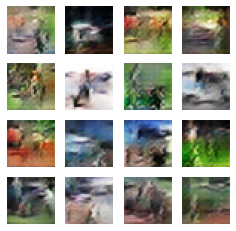

Time for training : 23063 sec


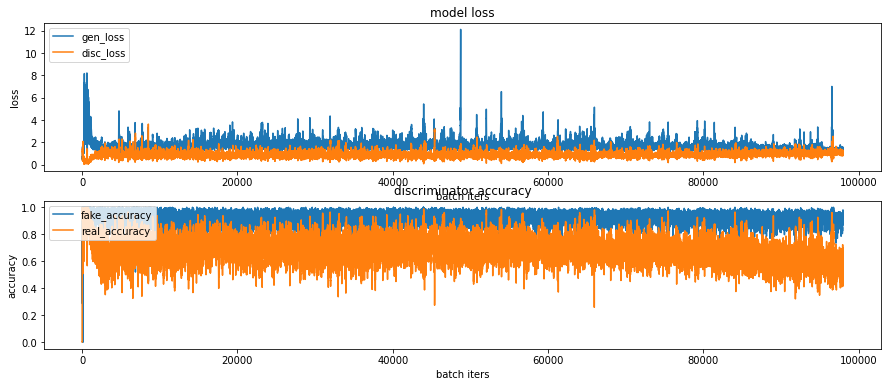

CPU times: user 6h 22min 38s, sys: 5min 2s, total: 6h 27min 41s
Wall time: 6h 24min 27s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

#학습과정의 loss, accuracy 그래프 이미지 파일이 지정한 경로에 생성될 것.

In [31]:
#샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만듦.
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples1/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif

-rw-r--r-- 1 root root 4000395 Aug 29 20:51 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif


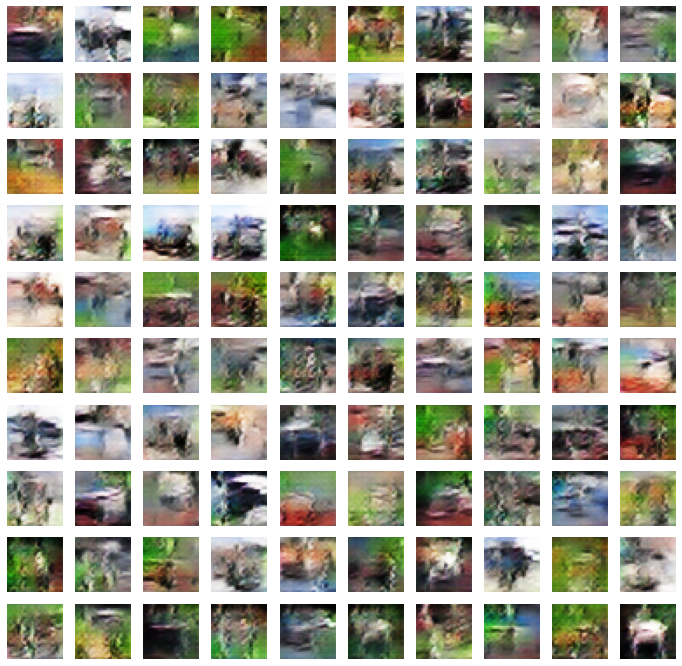

In [32]:
#checkpoint 모듈을 활용하여 모델을 로드
#학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있음.
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

#로드한 모델이 정상적으로 이미지를 생성하는지 확인. 
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   #역정규화를 하여 이미지를 출력
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

## 7. GAN 훈련 과정 개선하기

### 1. 노드(baseline) 모델 결과      

| 샘플 이미지들 합친 gif 파일 | 마지막으로 생성된 샘플 이미지 |  
|:--:|:--:|
| ![gif](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/cifar10_50.gif?raw=true) | ![샘플](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/sample_50.JPG?raw=true) |   

| loss, accuracy 결과 |   
|:--:|   
| ![history](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/history_50.JPG?raw=true) |   


- 기본 모델로만 모델을 학습 했을 때는 제대로 된 형체도 볼 수 없었으며 마지막으로 저장한 샘플 이미지 또한 엉망이었다.   
- loss가 0으로 수렴하고 fake_accuracy 또한 감소해야 좋은 결과라고 볼 수 있는데, loss와 fake_accuracy 모두 좋지 못한 결과로 나왔다.   
- 결과물이 흐릿하기 때문에 보다 나은 결과물을 얻고자 에폭을 늘려보기로 했다.   

### 2. 노드(baseline) 모델에서 에폭을 50에서 500으로 변경한 결과   
| 샘플 이미지들 합친 gif 파일 | 마지막으로 생성된 샘플 이미지 |  
|:--:|:--:|
| ![gif 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/cifar10_base.gif?raw=true)| ![마지막 샘플 이미지](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/sample_base_500.JPG?raw=true) |   

| loss, accuracy 결과 |   
|:--:|   
| ![history 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/history_base_500_1.JPG?raw=true) |   


- 시도 1보다는 좋은 결과인 것으로 보이지만 여전히 loss는 0에 수렴하지 않으며 fake_accuracy 또한 감소하는 양상을 보이진 않았다.   
- 마지막으로 생성된 샘플 이미지를 보면 에폭 50(시도1)일 때 보다는 형체가 생기긴 했지만 뚜렷한 형체라고는 말하기 힘든 결과물이 나왔다.   
- 하지만 에폭이 50(시도1)일 때보다 샘플 이미지 결과도 좋아졌고 loss가 줄어든 것을 보아 에폭을 늘리는 것이 성능 개선에 효과가 있다고 판단하였고 두번째 시도에서는 에폭을 500으로 유지한 채 모델의 구조와 하이퍼 파라미터를 바꾸는 방향으로 시도해 보고자 하였다.   

### 3. 에폭은 500으로 유지한 채 모델의 구조와 하이퍼파라미터 값을 아래와 같이 변경한 결과      
- 생성자 모델 : BatchNormalization을 없애고 LeakyReLU의 alpha값을 0.2로 지정함.    
- 판별자 모델 : LeakyReLU의 alpha값을 0.2로 지정하고 Dropout 위치를 조정함.
| 샘플 이미지들 합친 gif 파일 | 마지막으로 생성된 샘플 이미지 |   
|:--:|:--:|   
| ![gif 파일](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/cifar10_new_new.gif?raw=true) | ![샘플](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/sample_new.JPG?raw=true) |   


| loss, accuracy 결과 |   
|:--:|   
| ![history](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/history_new.JPG?raw=true) |    



| checkpoint로 모델을 로드하여 생성한 이미지 |   
|:--:|   
| ![check](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex13/results/check_new.jpg?raw=true)|


- 모델의 구조와 하이퍼 파라미터를 조금 바꾸었을 뿐인데도 loss가 0에 수렴하는 것을 볼 수 있었다. real_accuracy는 조금씩 줄어드는 것이 보이지만 fake_accuracy는 줄어드는 양상을 보이지 않았다.   
- gif 파일을 봤을 때는 시도2보다 좀 더 선명한 형체를 만들어가는 것 같지만 오히려 마지막으로 생성한 샘플 이미지를 시도2와 비교하면 오히려 형체를 더 알아보기 힘든 것 같기도 하다.   
- checkpoint로 모델을 로드하여 생성한 이미지를 보았을 때 역시 뚜렷한 형태라고는 말할 수 없지만 팔, 다리가 달렸는지 정도는 판단할 수 있는 것 같기도 하다.   

---

## - 프로젝트 정리   
- 노드에서 실습한 기본(baseline) 모델보다 확실히 하이퍼 파라미터나 모델의 구조를 조금이라도 변경한 결과가 더 좋다는 것을 알 수 있었다.   
- 에폭을 늘리는 것만으로도 결과 개선에 영향을 주는 것도 볼 수 있었으며, 모델의 구조를 바꾸고 하이퍼 파라미터를 변경했을 때는 훨씬 더 좋은 결과를 얻을 수 있는 것으로 보아 모델 레이어를 좀 더 깊게 쌓으면 샘플 이미지 또한 형체가 뚜렷해지지 않을까 생각을 하기도 했다.   
- 모델의 구조를 변경하지 않고 원본 이미지의 사이즈를 늘리고 보간법을 이용해 경계를 좀 더 부드럽게 바꾼다면 에폭만 늘려도 좋은 결과물이 나오지 않을까 생각도 해 보았다.   
- 체크포인트 활용을 잘 했으면 모델 학습에 시간을 많이 소요하지 않았을 것 같은데 체크포인트 사용을 제대로 할 줄 몰랐던 것 같다.    
- 때문에 모델 학습 소요 시간이 너무 오래 걸려 더 많은 시도를 못 해 본 것이 아쉽다.   